# WeatherPy
----

#### Note
* The following plots and figures analyse real weather data to show the relationship temperature relationship between latatude and temperature, specifically, the closer you are to the equator, the higher the temperature.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import scipy.stats as st
import os.path
from os import path

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "../output_data/city_weather.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Define Get Cities

In [2]:
def get_cities(mincitycount):
    # List for holding lat_lngs and cities
    lat_lngs = []
    cities = []

    while (len(cities) < mincitycount):
        # Create a set of random lat and lng combinations
        lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
        lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
        lat_lngs = zip(lats, lngs)

        # Identify nearest city for each lat, lng combination
        for lat_lng in lat_lngs:
            city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

            # If the city is unique, then add it to a our cities list
            if city not in cities:
                cities.append(city)

    return cities;    

## Define Get Weather API

In [3]:
def get_weather_api(cities):
    url = "http://api.openweathermap.org/data/2.5/weather?"
    units = "imperial"

    i = 0
    weather_data = []

    for city in cities:
        print(f"Index {str(i)} fetching weather for {city}")
    
        # Build query URL
        query_url = f"{url}appid={weather_api_key}&units={units}&q={city}"

        # increment index counter
        i += 1

        # Get weather data    
        weather_response = requests.get(query_url)
        weather_json = weather_response.json()
        weather_data.append(weather_json)        
        time.sleep(1)    
        
    return weather_data
    

## Define Get Weather Dataframe

In [4]:
def get_weather_dataframe(weather_data):
    # define lists for cities, countries, date, latitude, longitude, temperature (F), max temperature (F), humidity, cloudiness, wind speed
    weather_cities = []
    countries = []
    date = []
    lat = []
    lon = []
    temp = []
    max_temp = []
    hum = []
    cloud = []
    wind = []

    for weather in weather_data:
        if (weather["cod"] == 200):        
            weather_cities.append(weather["name"])
            countries.append(weather["sys"]["country"])
            date.append(weather["dt"])        
            lat.append(weather["coord"]["lat"])
            lon.append(weather["coord"]["lon"])
            temp.append(weather["main"]["temp"]) 
            max_temp.append(weather["main"]["temp_max"]) 
            hum.append(weather["main"]["humidity"])
            cloud.append(weather["clouds"]["all"])        
            wind.append(weather["wind"]["speed"]) 
            
    # create a data frame for columns: cities, countries, date, lat, long, temp, max temp, humidity, cloudiness, and wind speed
    weather_dict = {
        "city": weather_cities,
        "country": countries,
        "date": date,
        "latitude": lat,
        "longitude": lon,    
        "temperature": temp,
        "max temperature": max_temp,
        "humidity": hum,
        "cloudiness": cloud,
        "wind speed": wind,

    }
    weather_df = pd.DataFrame(weather_dict)
    return weather_df    

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [5]:
# check if output_data_file exists already, if it doesn't exist, do api call to get weather data
if (path.exists(output_data_file)):
    # ****************
    # pull prevously generated and saved output data from csv
    weather_df = pd.read_csv(output_data_file)
else:    
    # get minimum 500 cities
    cities = get_cities(500)

    # Print the city count to confirm sufficient count
    print(f"City count {len(cities)}")

    # run api calls for each city in get_weather_api 
    # this step is skipped if the output_data_file already exists
    # delete output file and re-run to generate new cities and retreive weather data for new set of random cities
    weather_rawdata = get_weather_api(cities)
    weather_df = get_weather_dataframe(weather_rawdata)
    
    # **************** 
    # save weather to csv
    weather_df.to_csv(output_data_file, index=True,index_label="city_id")  

### Convert Raw Data to DataFrame
* Add weather data to dataframe
* Export the weather data into a .csv.
* Display weather datafram

In [6]:
# print weather_df
weather_df

,city_id,city,country,date,latitude,longitude,temperature,max temperature,humidity,cloudiness,wind speed
0,0,Jamestown,US,1609646793,42.10,-79.24,31.30,32.00,100,90,4.70
1,1,Busselton,AU,1609646876,-33.65,115.33,78.24,79.00,41,99,5.01
2,2,Bonavista,CA,1609646878,48.65,-53.11,21.20,21.20,85,100,1.12
3,3,Coxim,BR,1609646879,-18.51,-54.76,77.14,77.14,71,47,4.56
4,4,Tutóia,BR,1609646880,-2.76,-42.27,80.10,80.10,82,82,12.28
...,...,...,...,...,...,...,...,...,...,...,...
579,579,Bushehr,IR,1609647640,28.97,50.84,59.00,59.00,87,0,11.70
580,580,Trabzon Province,TR,1609647642,40.92,39.83,48.20,48.20,87,75,5.82
581,581,Erenhot,CN,1609647643,43.65,111.98,-1.28,-1.28,84,70,3.85
582,582,Sept-Îles,CA,1609647605,50.20,-66.38,16.68,19.40,85,90,4.70


In [7]:
# get humidity outliers index (where humidity % > 0)
list_humidity_outlier_index = []
humidity_outlier_df = weather_df.loc[weather_df["humidity"] > 100]
if (len(humidity_outlier_df) > 0):
    list_humidity_outlier_index = humidity_outlier_df.index.tolist()

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [8]:
#  Get the indices of cities that have humidity over 100%.
if (len(list_humidity_outlier_index) > 0):
    print(f"Dropping {len(list_humidity_outlier_index)} humidity outliers (humidity over 100)")
    
    # Make a new DataFrame equal to the city data to drop all humidity outliers by index.
    # Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
    clean_weather_df = weather_df.drop(weather_df.index[list_humidity_outlier_index], inplace = False)        
else: 
    print(f"Dropping zero humidity outliers (no weather in weather_df with humidity > 100)")
    clean_weather_df = weather_df

# verify dataframe counts, if no outliers counts should be the same
# if outliers dropped, clean_weather_df dataframe should be len(list_humidity_outlier_index) less than weather_df
print(f"Weather dataframe count: {len(weather_df)}")
print(f"Clean weather dataframe count: {len(clean_weather_df)}")        

Dropping zero humidity outliers (no weather in weather_df with humidity > 100)
Weather dataframe count: 584
Clean weather dataframe count: 584


In [9]:
# view clean_weather_df
clean_weather_df

,city_id,city,country,date,latitude,longitude,temperature,max temperature,humidity,cloudiness,wind speed
0,0,Jamestown,US,1609646793,42.10,-79.24,31.30,32.00,100,90,4.70
1,1,Busselton,AU,1609646876,-33.65,115.33,78.24,79.00,41,99,5.01
2,2,Bonavista,CA,1609646878,48.65,-53.11,21.20,21.20,85,100,1.12
3,3,Coxim,BR,1609646879,-18.51,-54.76,77.14,77.14,71,47,4.56
4,4,Tutóia,BR,1609646880,-2.76,-42.27,80.10,80.10,82,82,12.28
...,...,...,...,...,...,...,...,...,...,...,...
579,579,Bushehr,IR,1609647640,28.97,50.84,59.00,59.00,87,0,11.70
580,580,Trabzon Province,TR,1609647642,40.92,39.83,48.20,48.20,87,75,5.82
581,581,Erenhot,CN,1609647643,43.65,111.98,-1.28,-1.28,84,70,3.85
582,582,Sept-Îles,CA,1609647605,50.20,-66.38,16.68,19.40,85,90,4.70


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [10]:
# define plot data serieses 
latitude = clean_weather_df["latitude"]
temps = clean_weather_df["temperature"]
humidity = clean_weather_df["humidity"]
cloud = clean_weather_df["cloudiness"]
wind = clean_weather_df["wind speed"]

## Latitude vs. Temperature Plot

Latitude vs. Temerature (F) scatter plot shows temperatures rising as you get closer to zero degrees latitude (equator), then as the latitude values increase greater than zero (increasing further from the equator), the temperature decreases steadily. 

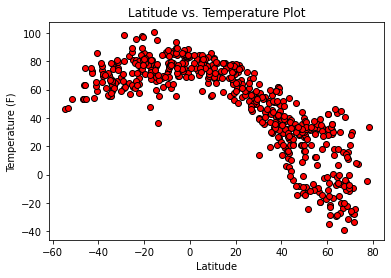

In [11]:
# Latitude vs. Temperature Plot
plt.title("Latitude vs. Temperature Plot")
plt.ylabel("Temperature (F)")
plt.xlabel("Latitude")

plt.scatter(latitude,temps,marker="o",color="red",edgecolors="black")
plt.savefig("../output_data/fig01_lat_temp.png")
plt.show()

## Latitude vs. Humidity (%) Plot

Latitude vs. Humidity (%) scatter plot does not appear to show a strong correlation.

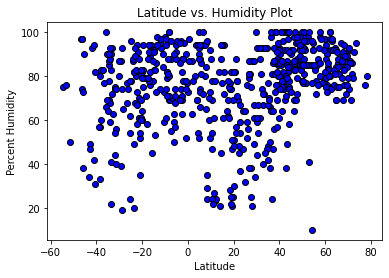

In [12]:
# Latitude vs. Humidity Plot
plt.title("Latitude vs. Humidity Plot")
plt.ylabel("Percent Humidity")
plt.xlabel("Latitude")

plt.scatter(latitude,humidity,marker="o", color="blue", edgecolors="black")
plt.savefig("../output_data/fig02_lat_hum.png")
plt.show()


## Latitude vs. Cloudiness Plot

Latitude vs. Cloudiness (%) scatter plot does not appear to show a strong correlation.

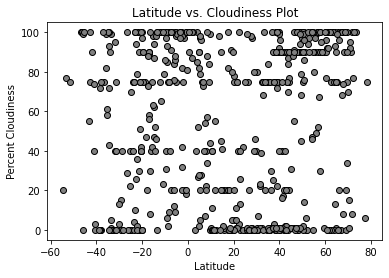

In [13]:
# Latitude vs. Cloudiness Plot
plt.title("Latitude vs. Cloudiness Plot")
plt.ylabel("Percent Cloudiness")
plt.xlabel("Latitude")

plt.scatter(latitude,cloud,marker="o", color="grey", edgecolors="black")
plt.savefig("../output_data/fig03_lat_cloud.png")
plt.show()


## Latitude vs. Wind Speed Plot

Latitude vs. Wind Speed scatter plot does not appear to show a strong correlation.

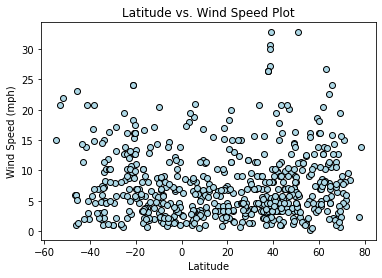

In [14]:
# Latitude vs. Wind Speed Plot
plt.title("Latitude vs. Wind Speed Plot")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")

plt.scatter(latitude,wind,marker="o", color="lightblue", edgecolors="black")
plt.savefig("../output_data/fig04_lat_wind.png")
plt.show()


## Linear Regression

### Define serieses for linear regression plots

In [15]:
# define serieses for linear regression plots

# latitudes northern/southern hemisphere
x_lat_nh = clean_weather_df.loc[clean_weather_df["latitude"] > 0]["latitude"] 
x_lat_sh = clean_weather_df.loc[clean_weather_df["latitude"] < 0]["latitude"] 

# Northnern/Southern Hemisphere - Max Temp
y_max_temps_nh = clean_weather_df.loc[clean_weather_df["latitude"] > 0]["max temperature"] 
y_max_temps_sh = clean_weather_df.loc[clean_weather_df["latitude"] < 0]["max temperature"] 

# Northern/Southern Hemisphere - Humidity (%)
y_hum_nh = clean_weather_df.loc[clean_weather_df["latitude"] > 0]["humidity"] 
y_hum_sh = clean_weather_df.loc[clean_weather_df["latitude"] < 0]["humidity"] 

# Northern/Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression
y_cloud_nh = clean_weather_df.loc[clean_weather_df["latitude"] > 0]["cloudiness"] 
y_cloud_sh = clean_weather_df.loc[clean_weather_df["latitude"] < 0]["cloudiness"] 

# Northern/Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression
y_wind_nh = clean_weather_df.loc[clean_weather_df["latitude"] > 0]["wind speed"] 
y_wind_sh = clean_weather_df.loc[clean_weather_df["latitude"] < 0]["wind speed"] 

In [16]:
def get_linearregressionplot(x_values, y_values, title, x_label, y_label, fig):
    # Calculate the correlation coefficient and linear regression model
    correlation = st.pearsonr(x_values,y_values)    
    
    # Linear Regression
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept    
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,"r-")    
    plt.annotate(line_eq,(min(x_values),max(y_values) - 5),fontsize=15,color="red")
    plt.annotate(f"R {str(round(correlation[0],2))}",(min(x_values),min(y_values)),fontsize=15,color="red")

    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.savefig(fig)
    plt.show()
    
    return correlation


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

Strong negative correlation coefficient (r value). In the northern hemisphere, the farther you are in degrees latitude from the equator, the temperature decreases steadily.

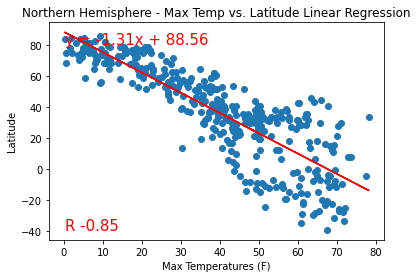

The correlation coefficient between Northern Hemisphere - Max Temp vs. Latitude Linear Regression is -0.85


In [17]:
title = "Northern Hemisphere - Max Temp vs. Latitude Linear Regression"
y_label = "Max Temperatures (F)"
x_label = "Latitude"
fig = "../output_data/fig05_correlation_latmaxtemp_nh.png"
    
correlation_latmaxtemp_nh = get_linearregressionplot(x_lat_nh,y_max_temps_nh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_latmaxtemp_nh[0],2)}")


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

Moderate positive correlation coefficient (r value). In the southern hemisphere, the closer you are in degrees latitude to the equator, the temperature increases moderately.

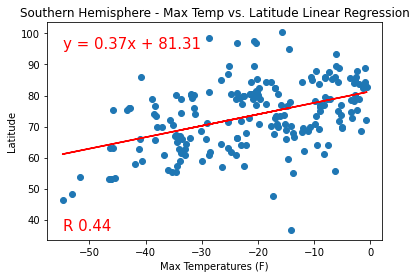

The correlation coefficient between Southern Hemisphere - Max Temp vs. Latitude Linear Regression is 0.44


In [18]:
title = "Southern Hemisphere - Max Temp vs. Latitude Linear Regression"
y_label = "Max Temperatures (F)"
x_label = "Latitude"
fig = "../output_data/fig06_correlation_latmaxtemp_sh.png"

correlation_latmaxtemp_sh = get_linearregressionplot(x_lat_sh,y_max_temps_sh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_latmaxtemp_sh[0],2)}")



####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Moderate positive correlation coefficient (r value). In the northern hemisphere, the farther you are in degrees latitude from the equator, the percent humidity increases moderately.

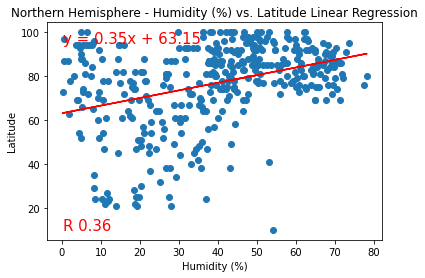

The correlation coefficient between Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression is 0.36


In [19]:
title = "Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression"
y_label = "Humidity (%)"
x_label = "Latitude"
fig = "../output_data/fig07_correlation_lathum_nh.png"


correlation_lathum_nh = get_linearregressionplot(x_lat_nh,y_hum_nh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_lathum_nh[0],2)}")


####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

Weak positive correlation coefficient (r value). In the southern hemisphere, the closer you are in degrees latitude to the equator, the percent humidity increases slightly.

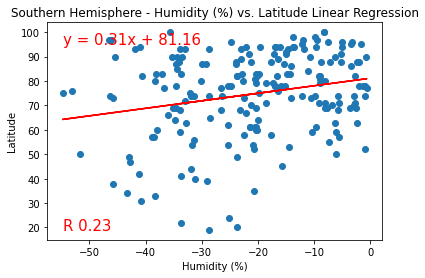

The correlation coefficient between Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression is 0.23


In [20]:
title = "Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression"
y_label = "Humidity (%)"
x_label = "Latitude"
fig = "../output_data/fig08_correlation_lathum_sh.png"

correlation_lathum_sh = get_linearregressionplot(x_lat_sh,y_hum_sh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_lathum_sh[0],2)}")


####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Weak positive correlation coefficient (r value). In the northern hemisphere, the farther you are in degrees latitude from the equator, the percent cloudiness increases slightly.

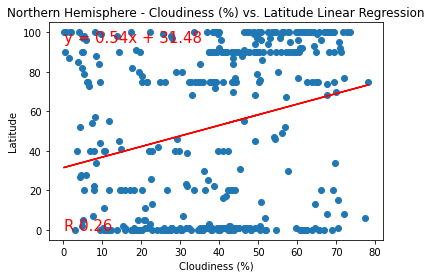

The correlation coefficient between Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression is 0.26


In [21]:
title = "Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression"
y_label = "Cloudiness (%)"
x_label = "Latitude"
fig = "../output_data/fig09_correlation_latcloud_nh.png"

correlation_latcloud_nh = get_linearregressionplot(x_lat_nh,y_cloud_nh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_latcloud_nh[0],2)}")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

Weak positive correlation coefficient (r value). In the southern hemisphere, the closer you are in degrees latitude to the equator, the percent cloudiness increases slightly.

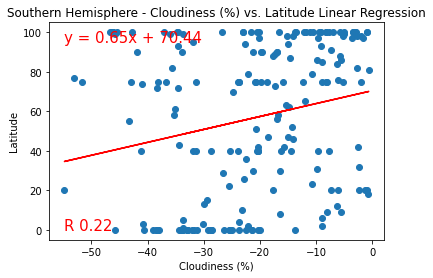

The correlation coefficient between Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression is 0.22


In [22]:
title = "Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression"
y_label = "Cloudiness (%)"
x_label = "Latitude"
fig = "../output_data/fig10_correlation_latcloud_sh.png"

correlation_latcloud_sh = get_linearregressionplot(x_lat_sh,y_cloud_sh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_latcloud_sh[0],2)}")



####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Very weak positive correlation coefficient (r value). In the northern hemisphere, the farther you are in degrees latitude from the equator, the wind speed (mph) increases a very slightly.


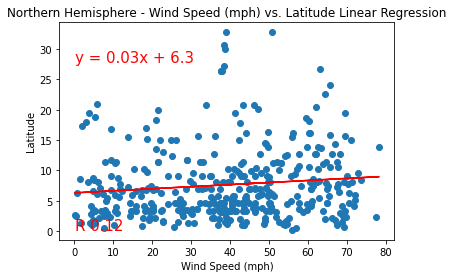

The correlation coefficient between Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression is 0.12


In [23]:
title = "Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression"
y_label = "Wind Speed (mph)"
x_label = "Latitude"
fig = "../output_data/fig11_correlation_latwind_nh.png"

correlation_latwind_nh = get_linearregressionplot(x_lat_nh,y_wind_nh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_latwind_nh[0],2)}")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

Very weak negative correlation coefficient (r value). In the southern hemisphere, the closer you are in degrees latitude to the equator, the wind speed (mph) decreases a very slightly.

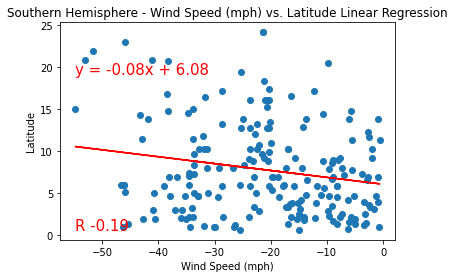

The correlation coefficient between Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression is -0.19


In [24]:
title = "Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression"
y_label = "Wind Speed (mph)"
x_label = "Latitude"
fig = "../output_data/fig12_correlation_latwind_sh.png"

correlation_latwind_sh = get_linearregressionplot(x_lat_sh,y_wind_sh, title, y_label, x_label, fig)
print(f"The correlation coefficient between {title} is {round(correlation_latwind_sh[0],2)}")


## Summary

In [25]:
correlation_items = []
correlation_items.append("Northern Hemisphere - Temperature (F) vs. Latitude")
correlation_items.append("Southern Hemisphere - Temperature (F) vs. Latitude")
correlation_items.append("Northern Hemisphere - Humidity (%) vs. Latitude")
correlation_items.append("Southern Hemisphere - Humidity (%) vs. Latitude")
correlation_items.append("Northern Hemisphere - Cloudiness (%) vs. Latitude")
correlation_items.append("Southern Hemisphere - Cloudiness (%) vs. Latitude")
correlation_items.append("Northern Hemisphere - Wind Speed (mph) vs. Latitude")
correlation_items.append("Southern Hemisphere - Wind Speed (mph) vs. Latitude")

r_values = []
r_values.append(round(correlation_latmaxtemp_nh[0],2))
r_values.append(round(correlation_latmaxtemp_sh[0],2))
r_values.append(round(correlation_lathum_nh[0],2))
r_values.append(round(correlation_lathum_sh[0],2))
r_values.append(round(correlation_latcloud_nh[0],2))
r_values.append(round(correlation_latcloud_sh[0],2))
r_values.append(round(correlation_latwind_nh[0],2))
r_values.append(round(correlation_latwind_sh[0],2))


lat_corr_summary_dict = {
    "Correlation": correlation_items,
    "R Values": r_values,
    
}
lat_corr_summary_df = pd.DataFrame(lat_corr_summary_dict)
lat_corr_summary_df.sort_values(["R Values"])


,Correlation,R Values
0,Northern Hemisphere - Temperature (F) vs. Lati...,-0.85
7,Southern Hemisphere - Wind Speed (mph) vs. Lat...,-0.19
6,Northern Hemisphere - Wind Speed (mph) vs. Lat...,0.12
5,Southern Hemisphere - Cloudiness (%) vs. Latitude,0.22
3,Southern Hemisphere - Humidity (%) vs. Latitude,0.23
4,Northern Hemisphere - Cloudiness (%) vs. Latitude,0.26
2,Northern Hemisphere - Humidity (%) vs. Latitude,0.36
1,Southern Hemisphere - Temperature (F) vs. Lati...,0.44


## Strongest negative correlation

#### Northern Hemisphere - Temperature (F) vs. Latitude


The max temperatures (F) (y-axis) are highest closest to the equator (latitue 0). As you get farther away from the equator (higher latitude value, x-axis), the max temperatures (F) decrease. 

![fig05_correlation_latmaxtemp_nh.png](../output_data/fig05_correlation_latmaxtemp_nh.png)

## Strongest positive correlation

#### Southern Hemisphere - Temperature (F) vs. Latitude


The temperatures (F) (y-axis) are lowest farther away from the equator (latitue 0). As you get closer to the equator (higher latitude value, x-axis), the max temperature (F) increases.

![fig06_correlation_latmaxtemp_sh.png](../output_data/fig06_correlation_latmaxtemp_sh.png)
